# Initialization

In [2]:
import dotenv
from dotenv import load_dotenv
import os
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")  
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")  
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")  # Instead of hardcoding

# astra_db_store = AstraDBVectorStore(
#     token=ASTRA_DB_APPLICATION_TOKEN,
#     api_endpoint=ASTRA_DB_API_ENDPOINT,
#     collection_name="auto_mail_project",
#     embedding_dimension=1536,
# )

# storage_context = StorageContext.from_defaults(vector_store=astra_db_store)

# index = VectorStoreIndex.from_documents(
#     documents=documents, storage_context=storage_context
# )

In [ ]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

# LLM with function call
from langchain_groq import ChatGroq
import os
llm=ChatGroq(groq_api_key=GROQ_API_KEY,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

In [25]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
import os

# Define the routing model with 20 specific categories
class RouteQuery(BaseModel):
    """Route a user query to the correct processing logic."""

    category: Literal[
        "pos_replace",
        "general_pricing_queries",
        "piggyback_creation",
        "adding_parts_to_piggyback",
        "ship_and_debit_queries",
        "opportunities_rejected_sfdc",
        "pending_approval_sfdc",
        "quote_closed_gpms_no_document",
        "quote_not_reaching_pricing",
        "customer_data_enquiries",
        "quotes_pending_review_gpms",
        "opportunities_pending_review_sfdc",
        "opportunity_rejected_incorrectly_sfdc",
        "loa_related_queries",
        "s_and_d_claim_rejection",
        "agreement_pn_addition_removal",
        "te_com_issues",
        "product_enquiry",
        "feedback",
        "complaint"
    ] = Field(..., description="Classify the user query into one of 20 specific routes.")

# Initialize LLM
llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="llama-3.3-70b-versatile")

# Structured LLM Router
structured_llm_router = llm.with_structured_output(RouteQuery)

# Routing Prompt
system_prompt = """You are an expert at classifying user queries into 20 specific categories:

- 'pos_replace' → POS update requests.
- 'general_pricing_queries' → Price adjustments, discounts, validity, quote extensions.
- 'piggyback_creation' → Requests to create a new piggyback under an OEM agreement.
- 'adding_parts_to_piggyback' → Requests to add parts or POS customers to an existing piggyback.
- 'ship_and_debit_queries' → Issues related to Ship & Debit, FSA conversion, customer address updates.
- 'opportunities_rejected_sfdc' → Handling rejections in SFDC.
- 'pending_approval_sfdc' → Requests for pending approvals in SFDC.
- 'quote_closed_gpms_no_document' → Quote closed in GPMS but document not available.
- 'quote_not_reaching_pricing' → Customer raised quote but it hasn’t reached pricing.
- 'customer_data_enquiries' → Requests for specific customer data.
- 'quotes_pending_review_gpms' → Checking quotes pending for review in GPMS.
- 'opportunities_pending_review_sfdc' → Checking opportunities pending for review in SFDC.
- 'opportunity_rejected_incorrectly_sfdc' → Incorrect rejection of an SFDC opportunity.
- 'loa_related_queries' → Issues related to LOA (Letter of Authorization).
- 's_and_d_claim_rejection' → Handling S&D claim rejections.
- 'agreement_pn_addition_removal' → Requests to add or remove parts in an agreement.
- 'te_com_issues' → Customer unable to raise SPRs due to issues on TE.com.
- 'product_enquiry' → General product-related enquiries (use Wikipedia search).
- 'feedback' → Feedback submissions (use a predefined template).
- 'complaint' → Complaint submissions (requires manual input).

Classify the user's question strictly into one of these categories.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

# Router Invocation
question_router = route_prompt | structured_llm_router

# Test the Router with Various Inputs
test_questions = [
    "Can you replace POS for quote #500xxxxx?",
    "What is the price adjustment policy?",
    "Can you create a piggyback for distributor ABC?",
    "I need to add PN 12345 to Piggyback P000XXX.",
    "What is the status of my S&D claim?",
    "My opportunity was rejected incorrectly on SFDC.",
    "Can I submit a complaint regarding poor service?",
    "I want to provide feedback about my recent experience."
]

for q in test_questions:
    print(f"Question: {q}")
    print("Category:", question_router.invoke({"question": q}).category)
    print("---")


Question: Can you replace POS for quote #500xxxxx?
Category: pos_replace
---
Question: What is the price adjustment policy?
Category: general_pricing_queries
---
Question: Can you create a piggyback for distributor ABC?
Category: piggyback_creation
---
Question: I need to add PN 12345 to Piggyback P000XXX.
Category: adding_parts_to_piggyback
---
Question: What is the status of my S&D claim?
Category: s_and_d_claim_rejection
---
Question: My opportunity was rejected incorrectly on SFDC.
Category: opportunity_rejected_incorrectly_sfdc
---
Question: Can I submit a complaint regarding poor service?
Category: complaint
---
Question: I want to provide feedback about my recent experience.
Category: feedback
---


In [26]:
from langgraph.graph import END, StateGraph, START

# Function for manual input (complaints)
def manual_input(state):
    print("Manual response required. Please provide input.")
    response = input("Enter response: ")
    return {"response": response}

# Function for wiki search (product enquiry)
def wiki_search(state):
    query = state["question"]
    print(f"Performing Wikipedia search for: {query}")
    return {"search_result": f"Wikipedia search result for '{query}'"}

# Function for yes/no decision-making
def yes_no_decision(state):
    question = state["question"]
    print(f"Decision required for: {question}")
    decision = input("Enter Yes or No: ").strip().lower()
    return {"decision": decision}

# Function for predefined responses
def predefined_response(state):
    return {"response": "Predefined response generated."}


In [27]:
# Define Workflow StateGraph
workflow = StateGraph(dict)

# Add Nodes for All 20 Routes
workflow.add_node("pos_replace", yes_no_decision)
workflow.add_node("general_pricing_queries", predefined_response)
workflow.add_node("piggyback_creation", yes_no_decision)
workflow.add_node("adding_parts_to_piggyback", predefined_response)
workflow.add_node("ship_and_debit_queries", predefined_response)
workflow.add_node("opportunities_rejected_sfdc", yes_no_decision)
workflow.add_node("pending_approval_sfdc", yes_no_decision)
workflow.add_node("quote_closed_gpms_no_document", predefined_response)
workflow.add_node("quote_not_reaching_pricing", predefined_response)
workflow.add_node("customer_data_enquiries", predefined_response)
workflow.add_node("quotes_pending_review_gpms", predefined_response)
workflow.add_node("opportunities_pending_review_sfdc", predefined_response)
workflow.add_node("opportunity_rejected_incorrectly_sfdc", predefined_response)
workflow.add_node("loa_related_queries", predefined_response)
workflow.add_node("s_and_d_claim_rejection", predefined_response)
workflow.add_node("agreement_pn_addition_removal", predefined_response)
workflow.add_node("te_com_issues", predefined_response)
workflow.add_node("product_enquiry", wiki_search)
workflow.add_node("feedback", predefined_response)
workflow.add_node("complaint", manual_input)
def fallback_node(state):
    return {"response": "I'm sorry, I couldn't classify your query. Please rephrase or contact support."}

workflow.add_node("fallback", fallback_node)
workflow.add_edge("fallback", END)  # Ensure fallback connects to END

# Routing Function
def route_question(state):
    question = state["question"].lower()

    mapping = {
        "pos replace": "pos_replace",
        "pricing": "general_pricing_queries",
        "create piggyback": "piggyback_creation",
        "add parts to piggyback": "adding_parts_to_piggyback",
        "ship & debit": "ship_and_debit_queries",
        "opportunity rejected": "opportunities_rejected_sfdc",
        "pending approval": "pending_approval_sfdc",
        "quote closed": "quote_closed_gpms_no_document",
        "quote not reaching pricing": "quote_not_reaching_pricing",
        "customer data": "customer_data_enquiries",
        "quotes pending": "quotes_pending_review_gpms",
        "opportunities pending": "opportunities_pending_review_sfdc",
        "rejected incorrectly": "opportunity_rejected_incorrectly_sfdc",
        "loa": "loa_related_queries",
        "s&d claim rejection": "s_and_d_claim_rejection",
        "agreement pn": "agreement_pn_addition_removal",
        "te.com issue": "te_com_issues",
        "product enquiry": "product_enquiry",
        "feedback": "feedback",
        "complaint": "complaint",
    }

    for key, value in mapping.items():
        if key in question:
            return value

    return "fallback"  # Ensures that an undefined route does not cause an error
# Ensures unknown queries are handled
# If no match, send to a fallback node


# Define Conditional Edges
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "pos_replace": "pos_replace",
        "general_pricing_queries": "general_pricing_queries",
        "piggyback_creation": "piggyback_creation",
        "adding_parts_to_piggyback": "adding_parts_to_piggyback",
        "ship_and_debit_queries": "ship_and_debit_queries",
        "opportunities_rejected_sfdc": "opportunities_rejected_sfdc",
        "pending_approval_sfdc": "pending_approval_sfdc",
        "quote_closed_gpms_no_document": "quote_closed_gpms_no_document",
        "quote_not_reaching_pricing": "quote_not_reaching_pricing",
        "customer_data_enquiries": "customer_data_enquiries",
        "quotes_pending_review_gpms": "quotes_pending_review_gpms",
        "opportunities_pending_review_sfdc": "opportunities_pending_review_sfdc",
        "opportunity_rejected_incorrectly_sfdc": "opportunity_rejected_incorrectly_sfdc",
        "loa_related_queries": "loa_related_queries",
        "s_and_d_claim_rejection": "s_and_d_claim_rejection",
        "agreement_pn_addition_removal": "agreement_pn_addition_removal",
        "te_com_issues": "te_com_issues",
        "product_enquiry": "product_enquiry",
        "feedback": "feedback",
        "complaint": "complaint",
    },
)

# Connect Nodes to END
routes = [
    "pos_replace",
    "general_pricing_queries",
    "piggyback_creation",
    "adding_parts_to_piggyback",
    "ship_and_debit_queries",
    "opportunities_rejected_sfdc",
    "pending_approval_sfdc",
    "quote_closed_gpms_no_document",
    "quote_not_reaching_pricing",
    "customer_data_enquiries",
    "quotes_pending_review_gpms",
    "opportunities_pending_review_sfdc",
    "opportunity_rejected_incorrectly_sfdc",
    "loa_related_queries",
    "s_and_d_claim_rejection",
    "agreement_pn_addition_removal",
    "te_com_issues",
    "product_enquiry",
    "feedback",
    "complaint",
    "fallback",  # Ensure fallback is included
]

for route in routes:
    workflow.add_edge(route, END)


# Compile the workflow
app = workflow.compile()




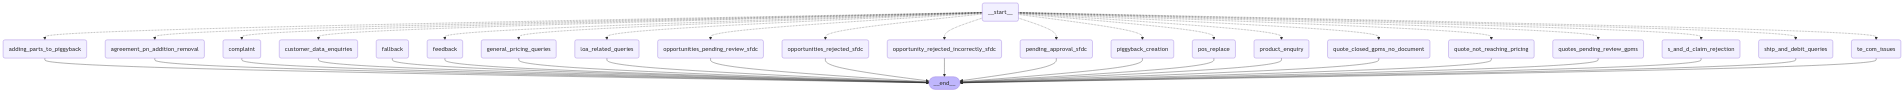

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [29]:
from pprint import pprint

# Test Input Example
inputs = {
    "question": "Can you replace POS for quote #500xxxxx?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}': {value}")

pprint("\n---\n")

# Final response
if "response" in value:
    pprint(value["response"])
elif "search_result" in value:
    pprint(value["search_result"])
elif "decision" in value:
    pprint(value["decision"])


KeyError: 'fallback'

In [ ]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
import os

# Define the routing model with 20 specific categories
class RouteQuery(BaseModel):
    """Route a user query to the correct processing logic."""

    category: Literal[
        "pos_replace",
        "general_pricing_queries",
        "piggyback_creation",
        "adding_parts_to_piggyback",
        "ship_and_debit_queries",
        "opportunities_rejected_sfdc",
        "pending_approval_sfdc",
        "quote_closed_gpms_no_document",
        "quote_not_reaching_pricing",
        "customer_data_enquiries",
        "quotes_pending_review_gpms",
        "opportunities_pending_review_sfdc",
        "opportunity_rejected_incorrectly_sfdc",
        "loa_related_queries",
        "s_and_d_claim_rejection",
        "agreement_pn_addition_removal",
        "te_com_issues",
        "product_enquiry",
        "feedback",
        "complaint",
        "fallback"  # Added fallback to the allowed categories
    ] = Field(..., description="Classify the user query into one of 21 specific routes.")

llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="llama-3.3-70b-versatile")

# Structured LLM Router
structured_llm_router = llm.with_structured_output(RouteQuery)

# Updated system prompt to include fallback
system_prompt = """You are an expert at classifying user queries into 21 specific categories:

- 'pos_replace' → POS update requests.
- 'general_pricing_queries' → Price adjustments, discounts, validity, quote extensions.
- 'piggyback_creation' → Requests to create a new piggyback under an OEM agreement.
- 'adding_parts_to_piggyback' → Requests to add parts or POS customers to an existing piggyback.
- 'ship_and_debit_queries' → Issues related to Ship & Debit, FSA conversion, customer address updates.
- 'opportunities_rejected_sfdc' → Handling rejections in SFDC.
- 'pending_approval_sfdc' → Requests for pending approvals in SFDC.
- 'quote_closed_gpms_no_document' → Quote closed in GPMS but document not available.
- 'quote_not_reaching_pricing' → Customer raised quote but it hasn’t reached pricing.
- 'customer_data_enquiries' → Requests for specific customer data.
- 'quotes_pending_review_gpms' → Checking quotes pending for review in GPMS.
- 'opportunities_pending_review_sfdc' → Checking opportunities pending for review in SFDC.
- 'opportunity_rejected_incorrectly_sfdc' → Incorrect rejection of an SFDC opportunity.
- 'loa_related_queries' → Issues related to LOA (Letter of Authorization).
- 's_and_d_claim_rejection' → Handling S&D claim rejections.
- 'agreement_pn_addition_removal' → Requests to add or remove parts in an agreement.
- 'te_com_issues' → Customer unable to raise SPRs due to issues on TE.com.
- 'product_enquiry' → General product-related enquiries (use Wikipedia search).
- 'feedback' → Feedback submissions (use a predefined template).
- 'complaint' → Complaint submissions (requires manual input).
- 'fallback' → For queries that don't match any other category

Classify the user's question strictly into one of these categories.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

# Router Invocation
question_router = route_prompt | structured_llm_router



from langgraph.graph import END, StateGraph, START

# Function for manual input (complaints)
def manual_input(state):
    print("Manual response required. Please provide input.")
    response = input("Enter response: ")
    return {"response": response}

# Function for wiki search (product enquiry)
def wiki_search(state):
    query = state["question"]
    print(f"Performing Wikipedia search for: {query}")
    return {"search_result": f"Wikipedia search result for '{query}'"}

# Function for yes/no decision-making
def yes_no_decision(state):
    question = state["question"]
    print(f"Decision required for: {question}")
    decision = input("Enter Yes or No: ").strip().lower()
    return {"decision": decision}

# Function for predefined responses
def predefined_response(state):
    return {"response": "Predefined response generated."}
def fallback_node(state):
    return {"response": "I'm sorry, I couldn't classify your query. Please rephrase or contact support."}

# Define Workflow StateGraph
workflow = StateGraph(dict)

# Add Nodes for All 20 Routes
workflow.add_node("pos_replace", yes_no_decision)
workflow.add_node("general_pricing_queries", predefined_response)
workflow.add_node("piggyback_creation", yes_no_decision)
workflow.add_node("adding_parts_to_piggyback", predefined_response)
workflow.add_node("ship_and_debit_queries", predefined_response)
workflow.add_node("opportunities_rejected_sfdc", yes_no_decision)
workflow.add_node("pending_approval_sfdc", yes_no_decision)
workflow.add_node("quote_closed_gpms_no_document", predefined_response)
workflow.add_node("quote_not_reaching_pricing", predefined_response)
workflow.add_node("customer_data_enquiries", predefined_response)
workflow.add_node("quotes_pending_review_gpms", predefined_response)
workflow.add_node("opportunities_pending_review_sfdc", predefined_response)
workflow.add_node("opportunity_rejected_incorrectly_sfdc", predefined_response)
workflow.add_node("loa_related_queries", predefined_response)
workflow.add_node("s_and_d_claim_rejection", predefined_response)
workflow.add_node("agreement_pn_addition_removal", predefined_response)
workflow.add_node("te_com_issues", predefined_response)
workflow.add_node("product_enquiry", wiki_search)
workflow.add_node("feedback", predefined_response)
workflow.add_node("complaint", manual_input)
workflow.add_node("fallback", fallback_node)
workflow.add_edge("fallback", END)  # Ensure fallback connects to END

def route_question(state):
    try:
        question = state["question"].lower()
        result = question_router.invoke({"question": question})
        return result.category
    except:
        return "fallback"

edges_map = {
    "pos_replace": "pos_replace",
    "general_pricing_queries": "general_pricing_queries",
    "piggyback_creation": "piggyback_creation",
    "adding_parts_to_piggyback": "adding_parts_to_piggyback",
    "ship_and_debit_queries": "ship_and_debit_queries",
    "opportunities_rejected_sfdc": "opportunities_rejected_sfdc",
    "pending_approval_sfdc": "pending_approval_sfdc",
    "quote_closed_gpms_no_document": "quote_closed_gpms_no_document",
    "quote_not_reaching_pricing": "quote_not_reaching_pricing",
    "customer_data_enquiries": "customer_data_enquiries",
    "quotes_pending_review_gpms": "quotes_pending_review_gpms",
    "opportunities_pending_review_sfdc": "opportunities_pending_review_sfdc",
    "opportunity_rejected_incorrectly_sfdc": "opportunity_rejected_incorrectly_sfdc",
    "loa_related_queries": "loa_related_queries",
    "s_and_d_claim_rejection": "s_and_d_claim_rejection",
    "agreement_pn_addition_removal": "agreement_pn_addition_removal",
    "te_com_issues": "te_com_issues",
    "product_enquiry": "product_enquiry",
    "feedback": "feedback",
    "complaint": "complaint",
    "fallback": "fallback"  
}

workflow.add_conditional_edges(
    START,
    route_question,
    edges_map
)

for route in edges_map.keys():
    workflow.add_edge(route, END)

app = workflow.compile()
if __name__ == "__main__":
    inputs = {
        "question": "Can you replace POS for quote #500xxxxx?"
    }
    
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Node '{key}': {value}")


Decision required for: Can you replace POS for quote #500xxxxx?
Node 'pos_replace': {'decision': 'yes'}


In [ ]:
email = "abczyx@gmail.com"
name = "Abc Xyz"
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are an automatic email reply AI. Based on the user's email, the retrieved info is about product details they asked. Explain and write a reply email, mention the product links in the reply. consider links only in the given text don't create links"
        },
        {
            "role": "user",
            "content": email + name + query + matching_text
        }
    ],
    model="llama3-8b-8192",
)

reply_content = chat_completion.choices[0].message.content
print(reply_content)

In [3]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
import os
from datetime import datetime
from langgraph.graph import END, StateGraph, START

class RouteQuery(BaseModel):
    """Route a user query to the correct processing logic."""

    category: Literal[
        "pos_replace",
        "general_pricing_queries",
        "piggyback_creation",
        "adding_parts_to_piggyback",
        "ship_and_debit_queries",
        "opportunities_rejected_sfdc",
        "pending_approval_sfdc",
        "quote_closed_gpms_no_document",
        "quote_not_reaching_pricing",
        "customer_data_enquiries",
        "quotes_pending_review_gpms",
        "opportunities_pending_review_sfdc",
        "opportunity_rejected_incorrectly_sfdc",
        "loa_related_queries",
        "s_and_d_claim_rejection",
        "agreement_pn_addition_removal",
        "te_com_issues",
        "product_enquiry",
        "feedback",
        "complaint",
        "fallback"  
    ] = Field(..., description="Classify the user query into one of 21 specific routes.")

def generate_email_response(email, name, query, category, response_data):
    system_prompt = {
    "pos_replace": """You are a TE Connectivity customer service AI. Write a formal email reply for a POS replacement request. 
                    First acknowledge the POS update request for the specific quote number. Mention that you have checked for potential conflicts with new POS customers. 
                    If conflicts are found, detail them. If no conflicts, confirm proceeding with the POS replacement.
                    Maintain a professional but helpful tone.""",
    
    "general_pricing_queries": """You are a TE Connectivity pricing specialist AI. Write a formal email reply addressing pricing queries.
                                Address specific aspects like volume discounts, validity, quote extensions, or quote status.
                                If quote is closed from TE's end, provide relevant details.
                                If quote is closed by BUPA, acknowledge and mention escalation to BUPA team.
                                Be clear and professional.""",
    
    "piggyback_creation": """You are a TE Connectivity specialist AI. Write a formal email reply for piggyback creation requests.
                            Acknowledge receipt of request from the specific distributor.
                            Reference the OEM agreement number provided.
                            Confirm receipt of LOA (Letter of Authorization).
                            Mention any uplift requirements if applicable.
                            Provide clear next steps.""",
        
    "adding_parts_to_piggyback": """You are a TE Connectivity specialist AI. Write a formal email reply regarding adding parts/POS to existing piggyback.
                                Acknowledge the request from the distributor.
                                Reference both the Piggyback number and linked OEM agreement.
                                Confirm the parts/POS customers to be added.
                                Outline next steps in the process.""",
    
    "ship_and_debit_queries": """You are a TE Connectivity specialist AI handling Ship & Debit queries.
                                Address FSA to S&D conversion requests or POS/END customer address updates.
                                If closed from TE's end, provide relevant details.
                                If closed by BUPA, mention escalation to BUPA team.
                                Be clear about next steps.""",
        
    "opportunities_rejected_sfdc": """You are a TE Connectivity specialist AI handling SFDC rejections.
                                    Address rejection reasons if from TE's end.
                                    If rejected by DMM, mention escalation to DMM team.
                                    Include any additional case findings.
                                    Provide clear next steps or alternatives.""",
    
    "pending_approval_sfdc": """You are a TE Connectivity specialist AI handling SFDC approval requests.
                            Acknowledge the opportunity number pending review.
                            Mention escalation to DMM for approval.
                            Include request to push to pricing after approval.
                            Be clear and professional.""",
        
    "quote_closed_gpms_no_document": """You are a TE Connectivity specialist AI handling GPMS document issues.
                                    Acknowledge quote verification on GPMS.
                                    Mention TEIS ticket creation for re-triggering quote to SAP.
                                    Provide next steps and expected resolution timeline.""",
    
    "quote_not_reaching_pricing": """You are a TE Connectivity specialist AI handling quote routing issues.
                                Acknowledge verification of quote on both GPMS & SFDC.
                                Mention TEIS ticket creation for re-triggering from SAP.
                                Address any pricing blocks identified.
                                Provide clear resolution steps.""",
    
    "customer_data_enquiries": """You are a TE Connectivity specialist AI handling customer data queries.
                                Reference specific customer lookup data requested.
                                Provide clear, concise information from authorized sources.
                                Maintain data privacy and confidentiality standards.""",
    
    "quotes_pending_review_gpms": """You are a TE Connectivity specialist AI handling GPMS review queries.
                                Acknowledge quote verification on GPMS.
                                If pending with TE, provide reason and ETA.
                                If on hold by BUPA, mention escalation to BUPA team.
                                Include any additional case findings.""",
    
    "opportunities_pending_review_sfdc": """You are a TE Connectivity specialist AI handling SFDC review queries.
                                        Verify opportunity status on SFDC.
                                        Mention escalation to correct DMM for approval.
                                        Request push to pricing after approval.
                                        Be clear about next steps.""",
    
    "opportunity_rejected_incorrectly_sfdc": """You are a TE Connectivity specialist AI handling incorrect SFDC rejections.
                                            Acknowledge the rejected opportunity number.
                                            Explain inability to revoke rejection.
                                            Guide customer to raise new opportunity with correct customer chain.
                                            Request immediate sharing of new reference number.""",
    
    "loa_related_queries": """You are a TE Connectivity specialist AI handling LOA queries.
                            Confirm LOA verification status.
                            If correct, mention updates to FAP/Piggyback.
                            If incorrect, clearly list missing details needed.
                            Request updated LOA if necessary.""",
    
    "s_and_d_claim_rejection": """You are a TE Connectivity specialist AI handling S&D claim rejections.
                                Acknowledge verification of quote/piggyback in GPMS.
                                Confirm if rejection is correct/incorrect.
                                Mention escalation to S&D team for resolution.
                                Provide next steps.""",
    
    "agreement_pn_addition_removal": """You are a TE Connectivity specialist AI handling agreement part number modifications.
                                    Confirm verification of agreement on GPMS.
                                    Acknowledge parts being queried.
                                    Mention escalation to agreement owner.
                                    Provide expected timeline for resolution.""",
    
    "te_com_issues": """You are a TE Connectivity specialist AI handling TE.com issues.
                    Guide customer to create support tickets for TE.com issues.
                    Provide clear instructions for ticket creation.
                    Include any relevant contact information or resources.""",
    
    "product_enquiry": """You are a TE Connectivity product specialist AI.
                        Provide detailed product information based on search results.
                        Include technical specifications when available.
                        Reference official TE product documentation.
                        Be clear and technical yet accessible.""",
    
    "feedback": """You are a TE Connectivity customer service AI handling feedback submissions.
                Acknowledge receipt of feedback professionally.
                Thank customer for their input.
                Explain how feedback will be processed.
                Provide any relevant follow-up steps.""",
    
    "complaint": """You are a TE Connectivity customer service AI handling complaints.
                Acknowledge the complaint with empathy and professionalism.
                Confirm understanding of the issue.
                Outline investigation and resolution steps.
                Provide timeline for response or resolution.""",
    
    "fallback": """You are a TE Connectivity customer service AI.
                Write a formal email reply acknowledging the query.
                Express understanding of the request.
                Direct customer to appropriate support channels.
                Provide alternative contact methods.
                Be professional and helpful."""
}

    current_date = datetime.now().strftime("%B %d, %Y")
    
    prompt = system_prompt.get(category, system_prompt["fallback"])
    
    formatted_prompt = f"""
{prompt}

Context:
Email: {email}
Name: {name}
Query: {query}
Response Data: {response_data}

Please generate a professional email response.
"""
    
    try:
        completion = llm.predict(formatted_prompt)
        
        email_template = f"""
Date: {current_date}

Dear {name},

{completion}

Best regards,
TE Connectivity Customer Support Team
        """
        
        return email_template
    except Exception as e:
        return f"Error generating email response: {str(e)}"


def manual_input(state):
    print("Manual response required. Please provide input.")
    response = input("Enter response: ")
    email = "abczyx@gmail.com"  
    name = "Abc Xyz"  
    email_response = generate_email_response(email, name, state["question"], "complaint", response)
    return {"response": email_response}

def predefined_response(state):
    category = state.get("category", "fallback")
    email = "abczyx@gmail.com"  
    name = "Abc Xyz"  
    response = "Predefined response for " + category
    email_response = generate_email_response(email, name, state["question"], category, response)
    return {"response": email_response}

def yes_no_decision(state):
    print(f"Decision required for: {state['question']}")
    decision = input("Enter Yes or No: ").strip().lower()
    email = "abczyx@gmail.com"  
    name = "Abc Xyz"  
    email_response = generate_email_response(email, name, state["question"], state.get("category", "fallback"), f"Decision: {decision}")
    return {"response": email_response}

def wiki_search(state):
    query = state["question"]
    print(f"Performing Wikipedia search for: {query}")
    search_result = f"Wikipedia search result for '{query}'"
    email = "abczyx@gmail.com"  
    name = "Abc Xyz"  
    email_response = generate_email_response(email, name, query, "product_enquiry", search_result)
    return {"response": email_response}

def fallback_node(state):
    email = "abczyx@gmail.com"  
    name = "Abc Xyz"  
    email_response = generate_email_response(email, name, state["question"], "fallback", "Unable to classify query")
    return {"response": email_response}


llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="llama-3.3-70b-versatile")

structured_llm_router = llm.with_structured_output(RouteQuery)

workflow = StateGraph(dict)

workflow.add_node("pos_replace", yes_no_decision)
workflow.add_node("general_pricing_queries", predefined_response)
workflow.add_node("piggyback_creation", yes_no_decision)
workflow.add_node("adding_parts_to_piggyback", predefined_response)
workflow.add_node("ship_and_debit_queries", predefined_response)
workflow.add_node("opportunities_rejected_sfdc", yes_no_decision)
workflow.add_node("pending_approval_sfdc", yes_no_decision)
workflow.add_node("quote_closed_gpms_no_document", predefined_response)
workflow.add_node("quote_not_reaching_pricing", predefined_response)
workflow.add_node("customer_data_enquiries", predefined_response)
workflow.add_node("quotes_pending_review_gpms", predefined_response)
workflow.add_node("opportunities_pending_review_sfdc", predefined_response)
workflow.add_node("opportunity_rejected_incorrectly_sfdc", predefined_response)
workflow.add_node("loa_related_queries", predefined_response)
workflow.add_node("s_and_d_claim_rejection", predefined_response)
workflow.add_node("agreement_pn_addition_removal", predefined_response)
workflow.add_node("te_com_issues", predefined_response)
workflow.add_node("product_enquiry", wiki_search)
workflow.add_node("feedback", predefined_response)
workflow.add_node("complaint", manual_input)
workflow.add_node("fallback", fallback_node)
workflow.add_edge("fallback", END)  

def route_question(state):
    try:
        question = state["question"].lower()
        result = question_router.invoke({"question": question})
        return result.category
    except:
        return "fallback"

edges_map = {
    "pos_replace": "pos_replace",
    "general_pricing_queries": "general_pricing_queries",
    "piggyback_creation": "piggyback_creation",
    "adding_parts_to_piggyback": "adding_parts_to_piggyback",
    "ship_and_debit_queries": "ship_and_debit_queries",
    "opportunities_rejected_sfdc": "opportunities_rejected_sfdc",
    "pending_approval_sfdc": "pending_approval_sfdc",
    "quote_closed_gpms_no_document": "quote_closed_gpms_no_document",
    "quote_not_reaching_pricing": "quote_not_reaching_pricing",
    "customer_data_enquiries": "customer_data_enquiries",
    "quotes_pending_review_gpms": "quotes_pending_review_gpms",
    "opportunities_pending_review_sfdc": "opportunities_pending_review_sfdc",
    "opportunity_rejected_incorrectly_sfdc": "opportunity_rejected_incorrectly_sfdc",
    "loa_related_queries": "loa_related_queries",
    "s_and_d_claim_rejection": "s_and_d_claim_rejection",
    "agreement_pn_addition_removal": "agreement_pn_addition_removal",
    "te_com_issues": "te_com_issues",
    "product_enquiry": "product_enquiry",
    "feedback": "feedback",
    "complaint": "complaint",
    "fallback": "fallback"  
}

workflow.add_conditional_edges(
    START,
    route_question,
    edges_map
)

for route in edges_map.keys():
    workflow.add_edge(route, END)

app = workflow.compile()


if __name__ == "__main__":
    inputs = {
        "question": "Can you replace POS for quote #500xxxxx?"
    }
    
    for output in app.stream(inputs):
        for key, value in output.items():
            if "response" in value:
                print("\nGenerated Email:\n")
                print(value["response"])
            else:
                print(f"Node '{key}': {value}")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25260\1912592080.py:180: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  completion = llm.predict(formatted_prompt)



Generated Email:


Date: February 28, 2025

Dear Abc Xyz,

Subject: Re: Query Regarding Quote #500xxxxx - Replacement of POS

Dear Mr. Xyz,

I am writing to acknowledge receipt of your email inquiry regarding quote #500xxxxx, specifically your request to replace the POS (Point of Sale). We appreciate the time you took to reach out to us, and we are more than happy to assist you with your query.

At TE Connectivity, we understand the importance of efficient and accurate processing of quotations. However, after reviewing your request, we require further clarification to ensure that we provide the most accurate and effective solution.

To better assist you, we recommend that you contact our dedicated Sales Support team, who will be able to address your specific needs and provide a prompt resolution. You can reach our Sales Support team through our website, where you can submit a request or find the relevant contact information for your region.

Alternatively, if you prefer to speak with 

In [2]:
manual_input_questions = [
    "We received a request from a distributor to create a piggyback for part numbers XYZ123. Can you confirm if any additional uplift is required?",
    "Customer is unable to retrieve the quote document from GPMS. Can you verify the quote and trigger a TEIS ticket if needed?",
    "There is an issue with TE.com where the customer cannot raise SPRs for PN XYZ456. Can you advise on the next steps?"
]

yes_no_questions = [
    "Can we replace POS for quote #500xxxxx as per the request?",
    "The opportunity #500xxxx has been rejected on SFDC. Should the customer raise a new opportunity?",
    "Quote #500xxxxx has been closed by BUPA. Should we escalate this to them?"
]

predefined_response_questions = [
    "What is the predefined response for a general pricing query related to a quote extension?",
    "How do we handle an enquiry regarding a rejected S&D claim?",
    "What is the process for adding a new part number to an existing piggyback agreement?"
]

wiki_search_questions = [
    "What is an OEM agreement and how does it relate to piggyback creation?",
    "Can you explain the process of ship & debit in the context of pricing adjustments?",
    "What is GPMS, and how does it work for quote management?"
]

fallback_questions = [
    "A distributor is requesting additional pricing information for an expired quote. How should we proceed?",
    "Customer is facing issues with updating LOA on their account. Can you assist?",
    "A quote has been marked as closed in GPMS but is still pending in SFDC. What action should be taken?"
]

if __name__ == "__main__":
    for question in yes_no_questions:
        inputs = {
            "question": "Can we replace POS for quote #500xxxxx as per the request?"
        }
        
        for output in app.stream(inputs):
            for key, value in output.items():
                if "response" in value:
                    print("\nGenerated Email:\n")
                    print(value["response"])
                else:
                    print(f"Node '{key}': {value}")



NameError: name 'app' is not defined

In [7]:
import mysql.connector
import pandas as pd

# MySQL connection details (Update these)
MYSQL_HOST = "localhost"
MYSQL_USER = "root"
MYSQL_PASSWORD = "12345678"  # Update with your actual MySQL password
MYSQL_DATABASE = "te_project_test_1"

# 1️⃣ Read the CSV file
csv_file_path = "ship_debit_queries.csv"  # Change this to your actual CSV path

# Try using ',' as delimiter first. If data still looks wrong, switch to '\t'.
df = pd.read_csv(csv_file_path, delimiter=",", encoding="utf-8")

# Print actual column names to check parsing
print("Actual Column Names:", df.columns.tolist())

# 🔹 Strip spaces, replace special characters, and convert to lowercase
df.columns = (
    df.columns.str.strip()
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace("&", "and")  # Replace '&' with 'and'
    .str.lower()
)

# Print after cleaning
print("Cleaned Column Names:", df.columns.tolist())

# 🔹 Correct Column Mapping  
column_mapping = {
    "quote_id": "Quote ID",
    "fsa_to_sandd_conversion": "FSA to S&D Conversion",  # Fixed '&' issue
    "pos_customer": "POS Customer",
    "end_customer": "End Customer",
    "address_issue": "Address Issue",
    "quote_closed_by": "Quote Closed By",
    "next_action_required": "Next Action Required",
    "additional_findings": "Additional Findings"
}

# Rename columns to match MySQL table schema
df.rename(columns={v: k for k, v in column_mapping.items()}, inplace=True)

# Ensure only relevant columns are selected
df = df[list(column_mapping.keys())]

# ✅ Convert DataFrame to list of tuples explicitly
data_tuples = [tuple(x) for x in df.to_numpy()]

# Debugging: Print a sample of the tuples
print("Sample Data:", data_tuples[:5])  # Print first 5 rows to verify format

# 2️⃣ Connect to MySQL and insert data
try:
    connection = mysql.connector.connect(
        host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, database=MYSQL_DATABASE
    )
    cursor = connection.cursor()

    # Define SQL INSERT query
    insert_query = """
    INSERT INTO quotes (Quote_ID, FSA_to_S_D_Conversion, POS_Customer, End_Customer, 
                        Address_Issue, Quote_Closed_By, Next_Action_Required, Additional_Findings)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    """

    # Insert data into MySQL
    cursor.executemany(insert_query, data_tuples)
    connection.commit()

    print("✅ CSV data uploaded successfully!")

except mysql.connector.Error as err:
    print(f"❌ Error: {err}")

finally:
    cursor.close()
    connection.close()


Actual Column Names: ['Quote ID', 'FSA to S&D Conversion', 'POS Customer', 'End Customer', 'Address Issue', 'Quote Closed By', 'Next Action Required', 'Additional Findings']
Cleaned Column Names: ['quote_id', 'fsa_to_sandd_conversion', 'pos_customer', 'end_customer', 'address_issue', 'quote_closed_by', 'next_action_required', 'additional_findings']
Sample Data: [(5007901340, 'No', 'Company A Corp', 'End F Ltd', 'Yes', 'Internal Team', 'Confirm update', 'No conflicts found'), (5002569607, 'Yes', 'Company B Corp', 'End G Ltd', 'Yes', 'BUPA', 'Address it to BUPA', 'Additional validation needed'), (5008486211, 'No', 'Company C Corp', 'End H Ltd', 'Yes', 'BUPA', 'Reply with details', 'Address mismatch'), (5003473411, 'Yes', 'Company D Corp', 'End I Ltd', 'Yes', 'Internal Team', 'Address it to BUPA', 'Approved for change'), (5001414860, 'Yes', 'Company E Corp', 'End J Ltd', 'No', 'BUPA', 'Address it to BUPA', 'Approved for change')]
✅ CSV data uploaded successfully!


In [1]:
import mysql.connector
from datetime import datetime

def get_ship_debit_info(quote_id):
    """Fetch Ship & Debit related information from database"""
    try:
        connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="12345678",
            database="te_project_test_1"
        )
        cursor = connection.cursor(dictionary=True)
        
        query = """
        SELECT * FROM quotes 
        WHERE Quote_ID = %s
        """
        cursor.execute(query, (quote_id,))
        result = cursor.fetchone()
        
        return result
        
    except mysql.connector.Error as err:
        print(f"Database Error: {err}")
        return None
    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()

def process_ship_debit_query(query):
    """Process Ship & Debit related queries and generate appropriate response"""
    # Extract quote ID using regex
    import re
    quote_match = re.search(r'#?(\d{10})', query)
    if not quote_match:
        return "Could not find a valid quote ID in the query. Please provide a 10-digit quote ID."
    
    quote_id = quote_match.group(1)
    quote_info = get_ship_debit_info(quote_id)
    
    if not quote_info:
        return f"No information found for Quote ID: {quote_id}"
    
    # Generate response based on quote status
    if quote_info['quote_closed_by'] == 'BUPA':
        response = f"""
Date: {datetime.now().strftime("%B %d, %Y")}

Dear Valued Customer,

Regarding your inquiry about Quote #{quote_id}:

This quote has been closed by BUPA. Please note the following details:
- FSA to S&D Conversion Status: {quote_info['fsa_to_sandd_conversion']}
- POS Customer: {quote_info['pos_customer']}
- End Customer: {quote_info['end_customer']}
- Address Issue: {quote_info['address_issue']}

Next Steps Required: {quote_info['next_action_required']}

Additional Findings: {quote_info['additional_findings']}

Please direct your follow-up queries to BUPA for further assistance.

Best regards,
TE Connectivity Support Team
"""
    else:
        response = f"""
Date: {datetime.now().strftime("%B %d, %Y")}

Dear Valued Customer,

Regarding your inquiry about Quote #{quote_id}:

Here are the details of your query:
- FSA to S&D Conversion Status: {quote_info['fsa_to_sandd_conversion']}
- POS Customer: {quote_info['pos_customer']}
- End Customer: {quote_info['end_customer']}
- Address Issue: {quote_info['address_issue']}
- Quote Status: Closed by {quote_info['quote_closed_by']}

Next Steps Required: {quote_info['next_action_required']}

Additional Information: {quote_info['additional_findings']}

Please let us know if you need any clarification or have additional questions.

Best regards,
TE Connectivity Support Team
"""
    return response

# Update the workflow nodes for ship_and_debit_queries
def handle_ship_debit_queries(state):
    """Handler for ship and debit related queries"""
    query = state["question"]
    response = process_ship_debit_query(query)
    return {"response": response}

# Update the workflow definition to use the new handler
workflow.add_node("ship_and_debit_queries", handle_ship_debit_queries)

# Test the functionality
if __name__ == "__main__":
    test_queries = [
        "Can you check the status of quote #5007901340 for ship and debit conversion?",
        "What's the status of FSA to S&D conversion for quote #5002569607?",
        "Need details about quote #5008486211 address issues"
    ]
    
    for test_query in test_queries:
        inputs = {"question": test_query}
        print(f"\nTesting query: {test_query}")
        print("-" * 80)
        
        for output in app.stream(inputs):
            for key, value in output.items():
                if "response" in value:
                    print(value["response"])
                else:
                    print(f"Node '{key}': {value}")
        print("-" * 80)

NameError: name 'workflow' is not defined